In [1]:
!pip install facenet-pytorch -q
!pip install expecttest -q
!pip install pytorch-metric-learning -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.10.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.


In [2]:
import cv2
import numpy as np
import pandas as pd
import os
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle
import glob
from pytorch_metric_learning import losses, miners, distances, reducers, samplers
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
from PIL import Image
import logging

from tqdm.auto import tqdm, trange
import time
import gc

ROOT_DIR = '/kaggle/input/'

In [3]:
import torch
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Since our dataset is highly imbalanced I will take only those classes with number of images >= 75

In [8]:
files = []
classnames = []

for idx, identity in enumerate(tqdm(os.listdir(ROOT_DIR))):
    identity_dir = os.path.join(ROOT_DIR, identity)
    if not len(os.listdir(identity_dir)) >= 75:
        
        continue
    image_files = [os.path.join(identity_dir, img) for img in os.listdir(identity_dir)]
    files.extend(image_files)
    classnames.extend([identity] * len(image_files))

        # Convert labels to numpy array for stratification
classnames = np.array(classnames)

  0%|          | 0/10575 [00:00<?, ?it/s]

In [9]:
df = pd.DataFrame({
    'filename': files,
    'classname': classnames
})

In [10]:
df['classname'].value_counts().nsmallest()

classname
0000402    75
0113158    75
0272706    75
0319698    75
0089456    75
Name: count, dtype: int64

In [11]:
print(f'Number of files: {len(files)}, unique classes: {len(np.unique(classnames))}')

Number of files: 200978, unique classes: 1292


Now the dataset does not have 495k images but has 201k of images and 1,292 classes

In [12]:
le = LabelEncoder()
encoded_classes = le.fit_transform(classnames)

with open('label_encoder.pkl', 'wb') as le_dump_file:
    pickle.dump(le, le_dump_file)

Let's split our data into train, validation and test datasets (80%/10%/10%)

In [13]:
train_files, temp_files = train_test_split(files, test_size=0.2, random_state=42, stratify=classnames)
temp_class_names = [file.split('/')[-2] for file in temp_files]
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42, stratify=temp_class_names)

In [14]:
train_num_unique = len(np.unique([file.split('/')[-2] for file in train_files]))
val_num_unique = len(np.unique([file.split('/')[-2] for file in val_files]))
test_num_unique = len(np.unique([file.split('/')[-2] for file in test_files]))
num_identities = train_num_unique
print(f'Num classes in train: {train_num_unique}, val: {val_num_unique}, test: {test_num_unique}')

Num classes in train: 1292, val: 1292, test: 1292


Train, validation and test datasets have the same number of unique classes

In [15]:
class CasiaWebfaceDataset(Dataset):
    def __init__(self, files: list, le: LabelEncoder, mode: str, 
                 transform = None, lib_transform = 'torchvision'):
        super().__init__()
        self.mode = mode
        self.files = sorted(files)
        self.dataset_len = len(self.files)
        self.data_modes = ['train', 'val', 'test']
        self.lib_transforms = ['torchvision', 'albumentations']
        self.lib_transform = lib_transform
        self.transform = transform
        
        self.le = le
        self.class_names = [file.split('/')[-2] for file in self.files]
        self.encoded_classes = self.le.transform(self.class_names)
        
        if self.mode not in self.data_modes:
            print(f'{self.mode} is not correct; correct modes: {self.data_modes}')
            raise NameError
            
        if self.lib_transform not in self.lib_transforms:
            print(f'{self.lib_transform} is not correct; correct libs: {self.lib_transforms}')
            raise NameError
            
        self.df = pd.DataFrame(data={'original': self.files, 'label': self.encoded_classes})
        label_dict = {}
            
        for label in trange(num_identities):
            positives = list(self.df[self.df.label == label].original.values)
            label_dict[label] = positives
    
        self.triple_df = pd.DataFrame({
            'label': label_dict.keys(),
            'positives': label_dict.values()
        })
        
    def load_sample_pil(self, file):
        image = Image.open(file)
        image.load()
        return image
        
    def load_sample_cv2(self, file):
        image = cv2.imread(file)[:, :, ::-1]
        return image
        
    def __getitem__(self, idx):
        if self.lib_transform == 'albumentations':
            x = self.load_sample_cv2(self.files[idx])
            transformed = self.transform(image=x)
            x = torch.from_numpy(transformed['image']).permute(2, 0, 1)
            
        elif self.lib_transform == 'torchvision':
            x = self.load_sample_pil(self.files[idx])
            x = self.transform(x)
            
        label = self.encoded_classes[idx]
         
        return x, label
    
    def __len__(self):
        return self.dataset_len

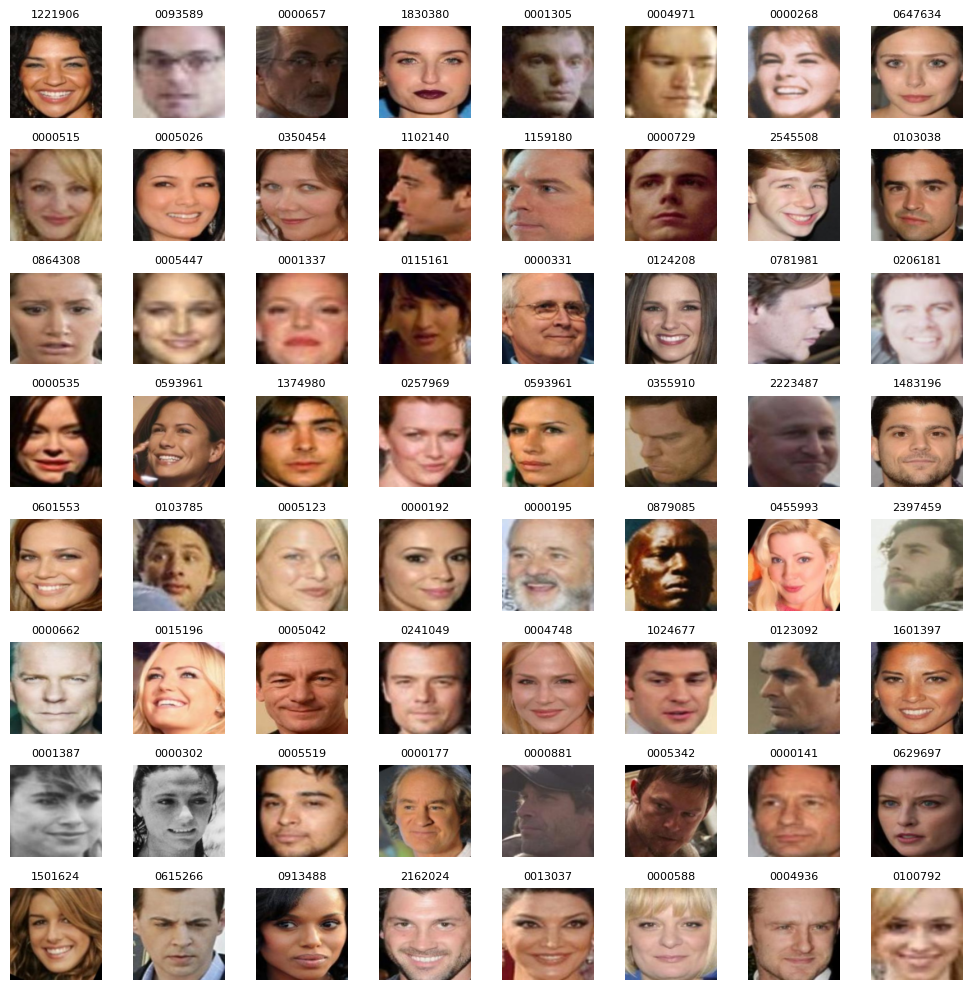

In [ ]:
rows, cols = 8, 8
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
axes = axes.flatten()

torch.manual_seed(42)
train_dataset = CasiaWebfaceDataset(train_files, le, 'train', transform)
dataloader = DataLoader(dataset=train_dataset, batch_size=rows*cols, shuffle=True)

images, labels = next(iter(dataloader))
images = images.permute(0, 2, 3, 1)

labels = le.inverse_transform(labels)

for i in range(rows*cols):
    axes[i].imshow(images[i])
    axes[i].set_title(labels[i], fontsize=8)
    axes[i].axis('off')
    
fig.tight_layout()

Our images are correctly detected and aligned using our MTCNN model

In [17]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

class EfficientNet(nn.Module):
    def __init__(self, num_embeddings, num_identities):
        super().__init__()
        self.backbone = efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)
        self.num_embeddings = num_embeddings
        self.num_identities = num_identities
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier[1] = nn.Linear(in_features=in_features,
                                                out_features=self.num_embeddings, bias=False)
        self.last_bn = nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True)

    def forward(self, x):
        x = self.backbone(x)
        x = self.last_bn(x)
        x = F.normalize(x, p=2, dim=1)
        return x

In [18]:
efficient_net = EfficientNet(512, 1292).to(DEVICE)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 58.2MB/s]


In [19]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [20]:
def update_history(history, train_loss, train_acc, val_loss, val_acc):
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_accuracy'].append(train_acc)
    history['val_accuracy'].append(val_acc)

In [47]:
def plot_results(history, name):
    fig, (loss_ax, acc_ax) = plt.subplots(2, 1, figsize=(12, 8))
    
    loss_ax.plot(history['train_loss'], label='train loss', marker='s', color='blue')
    loss_ax.plot(history['val_loss'], label='val loss', marker='s', color='red')
    loss_ax.legend()
    loss_ax.set_xlabel('epochs')
    loss_ax.set_ylabel('loss')
    loss_ax.set_title('Training vs validation loss')
    loss_ax.set_xticks(range(len(history['train_loss'])))
    loss_ax.set_xticks(ticks=range(len(history['train_loss'])), labels=range(1, len(history['train_loss']) + 1))
    
    acc_ax.plot(history['train_accuracy'], label='train accuracy', marker='s', color='blue')
    acc_ax.plot(history['val_accuracy'], label='val accuracy', marker='s', color='red')
    acc_ax.legend()
    acc_ax.set_xlabel('epochs')
    acc_ax.set_ylabel('accuracy')
    acc_ax.set_title('Training vs validation accuracy')
    acc_ax.set_xticks(range(len(history['train_accuracy'])))
    acc_ax.set_xticks(ticks=range(len(history['train_accuracy'])), labels=range(1, len(history['train_accuracy']) + 1))
    
    fig.tight_layout()
    fig.suptitle(f'Comparison of loss and accuracy for {name}', y=1.05)

It's quite hard to calculate accuracy when using Arcface / Triple loss because we does not have a classification layer. But we can calculate accuracy using the nearest mean embedding. We simply after each training epoch calculating average train emebedding for each identitiy and we predicted the identity correctly if label of current identity and the nearest mean embeddings are the same

In [22]:
def generate_mean_embeddings(model, epoch):
    model.eval()

    with torch.no_grad():
        for label in tqdm(range(num_identities)):
            positives = list(train_dataset.df[train_dataset.df.label == label].original.values)
            label_tensors = torch.stack([torch.from_numpy(train_dataset.transform(image=cv2.imread(i)[:, :, ::-1])['image']).permute(2, 0, 1) for i in positives])
            label_embedding = model(label_tensors.to(DEVICE)) 
            label_embedding = label_embedding.cpu().detach().numpy()
            label_mean_embedding = np.expand_dims(np.mean(label_embedding, 0), 0)
            if label == 0:
                list_embeddings = label_mean_embedding
                continue
            list_embeddings = np.concatenate((list_embeddings, label_mean_embedding), 0)
    np.save(f'mean_embeddings(epoch={epoch}).npy', list_embeddings)
    return list_embeddings

Let's define our functions for training and validation

In [23]:
def fit_epoch(model, train_loader, criterion, optimizer, mining_func, current_epoch, num_epochs, scheduler=None, list_embeddings=None, print_every = 100):
    model.train()
    running_loss = 0
    running_corrects = 0
    num_processed = 0
    num_indices = 0
    
    pbar = tqdm(train_loader, desc=f'Train epoch: [{current_epoch+1}/{num_epochs}]', total=len(train_loader))

    for images, labels in pbar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()

        embeddings = model(images)
        indices_tuple = mining_func(embeddings, labels)
        loss = criterion(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            running_loss += loss.item() * len(indices_tuple[0])
            num_processed += len(labels)
            num_indices += len(indices_tuple[0])
            
            if list_embeddings is not None:
                cos = cosine_similarity(embeddings.cpu(), list_embeddings)
                result = torch.argmax(torch.Tensor(cos), 1).to(DEVICE)
                num_corrects = torch.sum(result == labels).item()
                running_corrects += num_corrects
                
        if current_epoch == 0:
            pbar.set_postfix(batch_loss=loss.item())
        else:
            pbar.set_postfix(batch_loss=loss.item(), batch_accuracy=num_corrects / len(labels))
        
    torch.cuda.empty_cache()
    gc.collect()
    
    train_loss = running_loss / num_indices
    train_acc = running_corrects / num_processed
    
    return train_loss, train_acc

In [24]:
def eval_epoch(model, val_loader, criterion, current_epoch, num_epochs, list_embeddings, print_every = 100):
    model.eval()
    running_loss = 0
    running_corrects = 0
    num_processed = 0
    running_accuracy = 0
    num_indices = 0
    
    print('Mean embeddings has been generated')
    
    pbar = tqdm(val_loader, desc=f'Val epoch: [{current_epoch+1}/{num_epochs}]', total=len(val_loader))
    
    with torch.no_grad():
        for images, labels in pbar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            embeddings = model(images)

            indices_tuple = mining_func(embeddings, labels)
            loss = criterion(embeddings, labels, indices_tuple)

            running_loss += loss.item() * len(indices_tuple[0])
            
            cos = cosine_similarity(embeddings.cpu(), list_embeddings)
            result = torch.argmax(torch.Tensor(cos), 1).to(DEVICE)
            num_corrects = torch.sum(result == labels).item()
            running_corrects += num_corrects

            num_processed += len(labels)
            num_indices += len(indices_tuple[0])
            pbar.set_postfix(batch_loss=loss.item(), batch_accuracy=num_corrects / len(labels))
        
    torch.cuda.empty_cache()
    gc.collect()
    
    val_loss = running_loss / num_indices
    val_acc = running_corrects / num_processed

    return val_loss, val_acc

In [25]:
torch.cuda.empty_cache()
gc.collect()

0

In [26]:
def train(model, train_loader, val_loader, criterion, optimizer, mining_func, num_epochs, 
          scheduler=None, early_stopper = None, path = 'model.pt', print_every = 100):
    history = {
        'train_loss': [], 'val_loss': [],
        'train_accuracy': [], 'val_accuracy': []
    }
    
    best_acc, best_loss, best_epoch = 0, float('inf'), 0
    for epoch in range(num_epochs):
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, mining_func, epoch, 
                                          num_epochs, scheduler, None if epoch == 0 else list_embeddings, print_every)
        
        list_embeddings = generate_mean_embeddings(model, epoch+1)
        
        val_loss, val_acc = eval_epoch(model, val_loader, criterion, epoch, num_epochs, list_embeddings, print_every)
        
        print(f'Epoch: {epoch+1}, train loss = {train_loss:.4f}, val loss = {val_loss:.4f}, '
              f'train accuracy = {train_acc:.4f}, val accuracy: {val_acc:.4f}, ')
            
        update_history(history, train_loss, train_acc, val_loss, val_acc)
            
        if scheduler is not None:
            print(f'lr before step: {optimizer.param_groups[0]["lr"]:.6f}' , end='')
            scheduler.step(val_loss)
            print(f', lr after = {optimizer.param_groups[0]["lr"]:.6f}')
        
        if val_loss < best_loss:
            best_acc = val_acc
            best_loss = val_loss
            best_epoch = epoch
            
            torch.save({
                'epoch': best_epoch+1,
                'accuracy': best_acc,
                'loss': best_loss,
                'optimizer_state_dict': optimizer.state_dict(),
                'model_state_dict': model.state_dict()
            }, path)
            
            print(f'The model with the best val accuracy has been saved!')
        
        if early_stopper is not None:
            if early_stopper.early_stop(val_loss):
                print(f'Early stop on epoch = {epoch}, best loss = {best_loss:.4f}, best acc = {best_acc:.4f}, best_epoch = {best_epoch+1}')
                break
                
    return history

In [27]:
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 128

train_transform = A.Compose([
    A.Resize(160, 160),  # Resize to (160, 160)
    A.HorizontalFlip(p=0.5),  # 50% chance of horizontal flip
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.0, p=0.5),  # Color Jitter
    A.GaussianBlur(blur_limit=(3, 7), p=0.25),  # Gaussian blur with a random kernel size between 3 and 7
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # ImageNet normalization
#     ToTensorV2()  # Convert to PyTorch tensor
])

# Validation transform in Albumentations
val_transform = A.Compose([
    A.Resize(160, 160),  # Resize to (160, 160)
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # ImageNet normalization
#     ToTensorV2()  # Convert to PyTorch tensor
])

train_dataset = CasiaWebfaceDataset(train_files, le, 'train', transform=train_transform, lib_transform = 'albumentations')
val_dataset = CasiaWebfaceDataset(val_files, le, 'val', transform=val_transform, lib_transform = 'albumentations')

train_sampler = samplers.MPerClassSampler(train_dataset.encoded_classes, 4, batch_size=128, length_before_new_iter=500000)
val_sampler = samplers.MPerClassSampler(val_dataset.encoded_classes, 4, batch_size=128, length_before_new_iter=62500)

train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=False, sampler=train_sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False, sampler=val_sampler, num_workers=4)

  0%|          | 0/1292 [00:00<?, ?it/s]

  0%|          | 0/1292 [00:00<?, ?it/s]

In [38]:
LR = 1e-3
NUM_EPOCHS = 11
distance = distances.CosineSimilarity()
optimizer = optim.Adam(params=efficient_net.parameters(), lr=LR)
reducer = reducers.ThresholdReducer(low=0)
criterion = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="hard"
)
early_stopper = EarlyStopper(patience=6, min_delta=0.01)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=4)

In [39]:
history = train(efficient_net, train_loader, val_loader, criterion, optimizer, mining_func, NUM_EPOCHS, 
                scheduler, early_stopper, 'casia_triplet.pt', 5)

Train epoch: [1/11]:   0%|          | 0/3906 [00:03<?, ?it/s]

  0%|          | 0/1292 [00:00<?, ?it/s]

Mean embeddings has been generated


Val epoch: [1/11]:   0%|          | 0/488 [00:00<?, ?it/s]

Epoch: 1, train loss = 0.1990, val loss = 0.1899, train accuracy = 0.0000, val accuracy: 0.5077, 
lr before step: 0.001000, lr after = 0.001000
The model with the best val accuracy has been saved!


Train epoch: [2/11]:   0%|          | 0/3906 [00:03<?, ?it/s]

  0%|          | 0/1292 [00:00<?, ?it/s]

Mean embeddings has been generated


Val epoch: [2/11]:   0%|          | 0/488 [00:00<?, ?it/s]

Epoch: 2, train loss = 0.1644, val loss = 0.1867, train accuracy = 0.3979, val accuracy: 0.5981, 
lr before step: 0.001000, lr after = 0.001000
The model with the best val accuracy has been saved!


Train epoch: [3/11]:   0%|          | 0/3906 [00:03<?, ?it/s]

  0%|          | 0/1292 [00:00<?, ?it/s]

Mean embeddings has been generated


Val epoch: [3/11]:   0%|          | 0/488 [00:00<?, ?it/s]

Epoch: 3, train loss = 0.1521, val loss = 0.1895, train accuracy = 0.5134, val accuracy: 0.6420, 
lr before step: 0.001000, lr after = 0.001000


Train epoch: [4/11]:   0%|          | 0/3906 [00:03<?, ?it/s]

  0%|          | 0/1292 [00:00<?, ?it/s]

Mean embeddings has been generated


Val epoch: [4/11]:   0%|          | 0/488 [00:00<?, ?it/s]

Epoch: 4, train loss = 0.1421, val loss = 0.1916, train accuracy = 0.5709, val accuracy: 0.6656, 
lr before step: 0.001000, lr after = 0.001000


Train epoch: [5/11]:   0%|          | 0/3906 [00:03<?, ?it/s]

  0%|          | 0/1292 [00:00<?, ?it/s]

Mean embeddings has been generated


Val epoch: [5/11]:   0%|          | 0/488 [00:00<?, ?it/s]

Epoch: 5, train loss = 0.1339, val loss = 0.1928, train accuracy = 0.6300, val accuracy: 0.6803, 
lr before step: 0.001000, lr after = 0.001000


Train epoch: [6/11]:   0%|          | 0/3906 [00:03<?, ?it/s]

  0%|          | 0/1292 [00:00<?, ?it/s]

Mean embeddings has been generated


Val epoch: [6/11]:   0%|          | 0/488 [00:00<?, ?it/s]

Epoch: 6, train loss = 0.1273, val loss = 0.1923, train accuracy = 0.6704, val accuracy: 0.6998, 
lr before step: 0.001000, lr after = 0.001000


Train epoch: [7/11]:   0%|          | 0/3906 [00:03<?, ?it/s]

  0%|          | 0/1292 [00:00<?, ?it/s]

Mean embeddings has been generated


Val epoch: [7/11]:   0%|          | 0/488 [00:00<?, ?it/s]

Epoch: 7, train loss = 0.1229, val loss = 0.1934, train accuracy = 0.7065, val accuracy: 0.7176, 
lr before step: 0.001000, lr after = 0.000200


Train epoch: [8/11]:   0%|          | 0/3906 [00:03<?, ?it/s]

  0%|          | 0/1292 [00:00<?, ?it/s]

Mean embeddings has been generated


Val epoch: [8/11]:   0%|          | 0/488 [00:00<?, ?it/s]

Epoch: 8, train loss = 0.1080, val loss = 0.1967, train accuracy = 0.8098, val accuracy: 0.7530, 
lr before step: 0.000200, lr after = 0.000200


Train epoch: [9/11]:   0%|          | 0/3906 [00:03<?, ?it/s]

  0%|          | 0/1292 [00:00<?, ?it/s]

Mean embeddings has been generated


Val epoch: [9/11]:   0%|          | 0/488 [00:00<?, ?it/s]

Epoch: 9, train loss = 0.1008, val loss = 0.2004, train accuracy = 0.8562, val accuracy: 0.7592, 
lr before step: 0.000200, lr after = 0.000200


Train epoch: [10/11]:   0%|          | 0/3906 [00:03<?, ?it/s]

  0%|          | 0/1292 [00:00<?, ?it/s]

Mean embeddings has been generated


Val epoch: [10/11]:   0%|          | 0/488 [00:00<?, ?it/s]

Epoch: 10, train loss = 0.0962, val loss = 0.1994, train accuracy = 0.8755, val accuracy: 0.7722, 
lr before step: 0.000200, lr after = 0.000200


Train epoch: [11/11]:   0%|          | 0/3906 [00:03<?, ?it/s]

  0%|          | 0/1292 [00:00<?, ?it/s]

Mean embeddings has been generated


Val epoch: [11/11]:   0%|          | 0/488 [00:00<?, ?it/s]

Epoch: 11, train loss = 0.0936, val loss = 0.2033, train accuracy = 0.8904, val accuracy: 0.7708, 
lr before step: 0.000200, lr after = 0.000200


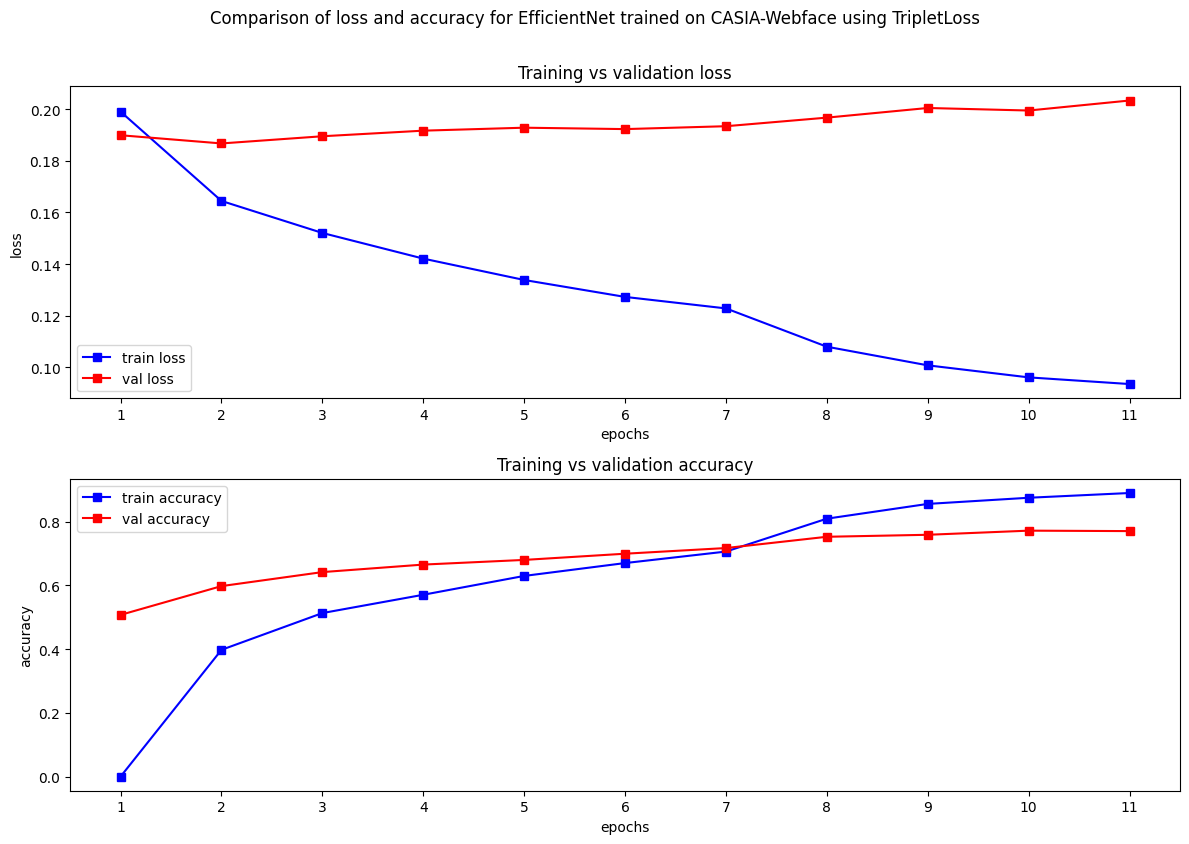

In [48]:
plot_results(history, 'EfficientNet trained on CASIA-Webface using TripletLoss')
plt.savefig('EfficientNet trained on CASIA-Webface using TripletLoss.png')

We got accuracy of 0.7708 what is not bad